In [79]:
import eventDrivenSimulation as eds
import simpy
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import show as sh
import requests
import folium
import haversine
import math
import bibliothek as bib
import random

## Data Generation

In [80]:
CONFIG = {}

CONFIG['LAT'] = 51.34053598409240
CONFIG['LON'] = 12.381419774766130
CONFIG['RADIUS'] = 500
CONFIG['NUM_UES'] = 1000
CONFIG['URL'] = 'https://pqos-api-test.radiolab.dit.htwk-leipzig.de' 

In [81]:
def create_sector_shape(lon, lat, dir=0, width=120):
    p = [(lat, lon)]
    n_points = 10
    
    for a in range(n_points):
        p.append(haversine.inverse_haversine(p[0], 0.05, (dir - width/2 + width/n_points*a)/180.0 * math.pi))
    
    p.append(p[0])
    return p

In [82]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)

ul_query_string = CONFIG['URL'] + '/generate_scenario' + \
                                  '?lat=' + str(CONFIG['LAT']) + \
                                  '&lon=' + str(CONFIG['LON']) + \
                                  '&radius=' + str(CONFIG['RADIUS']) + \
                                  '&num_ues=' + str(CONFIG['NUM_UES']) + \
                                '&cell_type=NGMN3600'

ul_response_data = requests.get(ul_query_string).json()
ue_data = ul_response_data['ue_data']
cell_data=ul_response_data['cell_data']
        
folium.Circle(radius = CONFIG['RADIUS'], 
              location = (CONFIG['LAT'], CONFIG['LON']), 
              color = 'blue', 
              fill_color = 'blue',
              fill_opacity = 0.1,
              fill = True,
              weight = 0,
             ).add_to(ul_scenario_map)            
        
for cell in cell_data:
    cell_color = '#1c86ee'
        

    folium.PolyLine(
        create_sector_shape(cell['lon'], cell['lat'], cell['az'], 60), 
        color = cell_color,
        fill_color = cell_color,
       fill_opacity = 0.5, 
        fill = True,
        weight = 2,
        #popup = 'RBs: ' + str(cell['ul_rb_requirement']['mean']),
        tooltip = 'PCI: ' + str(cell['pci'])).add_to(ul_scenario_map)
    
    folium.Circle(radius = 10, 
                  location = (cell['lat'], cell['lon']), 
                  color = 'black', 
                  fill_color = 'black',
                  fill_opacity = 1,
                  fill = True,
                  weight = 0,
                  popup = cell['site_name']
                 ).add_to(ul_scenario_map)


display(ul_scenario_map)

In [83]:
import numpy as np
import random
kkk=np.array([2,3,4,5])

In [84]:
df_ue=pd.DataFrame(ue_data)

In [85]:
df_cell = pd.DataFrame(cell_data)

In [86]:
sectors=df_cell['pci'].unique()

In [87]:
bs_dict={}
for i in df_cell.index:
    bs_dict.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lon'],df_cell.loc[i]['lat']]})

In [88]:
user_dataframe=pd.DataFrame()
x=np.array([])
for i in df_ue['id']:
    dic=df_ue.loc[i]['cell_info']
    powers={}
    pos=df_ue.loc[i]['pos']
    powers.update({'lat':pos[0]})
    powers.update({'lon':pos[1]})
    for i in dic:
        powers.update({i['pci']:i['dl_rx_power']})
    x=np.append(x,powers)
user_dataframe = pd.DataFrame.from_records(x)

## Preprocessing & CoMP Calculations

Settings for the CoMP Calculations: 
* noise power = -104 dBm

P=vector with receiving powers from all PCIs (N)

**SINR without CoMP**: $\frac{P_{0}}{P_{N}+P_{1:N}}$

**SINR with CoMP (2 coord. PCIs)** : $\frac{(\sqrt{P_{0}}+\sqrt{P_{1}})^2}{P_{N}+P_{2:N}}$

In [89]:
noise=np.power(10,-104/10) #https://www.sciencedirect.com/topics/engineering/noise-power -> 10MHz bandwidth (50PRBs)
cluster=sectors #all the cells are put in one cluster

In [90]:
df=user_dataframe.copy()
SINR_list=np.array([])
SINRwithCoMP_list=np.array([])
SINRwithCoMP_phaseshiftList=np.array([])
tp_1_list=np.array([])
tp_2_list=np.array([])
for i in np.arange(0, len(df)):
    P=df.loc[i,:][2:] #goes through file line by line and selects the line
    P=np.power(10, P/10) # calculate the linear values for capacity calculations
    P=P.sort_values(ascending=False) # sort values by their order
    A=np.sqrt(P) #calculate the amplitude
    index=P.index.values #Extract all index values 
    index=index.astype(np.int) #PCIen as integer
    A=np.array(A)
    P=np.array(P)
    SINR= P[0]/(np.sum(P[1:])+noise)
    SINRwithCoMP= np.power(np.sum(A[0:2]),2)/(np.sum(P[2:])+noise)
    #phi=random.gauss(0, math.pi)
    phi=random.gauss(0, math.pi/4)
    SINRwithCoMP_phaseshift=10*np.log10((np.power(A[0]+A[1]*np.cos(phi),2)+np.power(A[1]*np.sin(phi),2))/(np.sum(P[2:])+noise))
    
    SINR_list=np.append(SINR_list,10*np.log10(SINR)) #appends the calculated elements
    SINRwithCoMP_list=np.append(SINRwithCoMP_list,10*np.log10(SINRwithCoMP))
    SINRwithCoMP_phaseshiftList=np.append(SINRwithCoMP_phaseshiftList,SINRwithCoMP_phaseshift)

    tp_1_list=np.append(tp_1_list,index[0])
    tp_2_list=np.append(tp_2_list,index[1])

##### Building the dataframe

In [91]:
df['lat']=user_dataframe['lat']
df['lon']=user_dataframe['lon']
df['SINR [dB]']=SINR_list
df['SINR-CoMP [dB]']=SINRwithCoMP_list
df['SINR-CoMP with phaseshift [dB]']=SINRwithCoMP_phaseshiftList
df['TP1']=tp_1_list.astype(int)
df['TP2']=tp_2_list.astype(int)
df['qos']=np.zeros(len(user_dataframe)) #not needed here -> all users are best effort -> 0
df['id']=np.arange(0,len(user_dataframe))

#### Define general parameters for the simulation

In [92]:
max_prb=50 #number of prbs defined by the system bandwidth
ue_nr=15 #number of ues per pci
metric=[1,1] #defines the exponents of the metric (standard metric is pf ->[1,1])

#### Sort out PCIs that have less than ue_nr users -> edge of the Scenario

In [93]:
np.unique(df['TP1'])

array([132, 133, 134, 251, 318, 319, 320, 631, 774, 775, 776, 901])

In [94]:
#check if the number of users (positions) for the serving pci is >10
df_filter=df.groupby('TP1')
count=0
for i in df['TP1'].unique():
    k=df_filter.get_group(i)
    if(len(k)<ue_nr):
        cluster=np.delete(cluster,count) #delete cells with less than 10 positions
        df=df[df['TP1']!=i]
    count+=1

In [95]:
df

lat        lon  168  169  170  757  758  756  105  107  ...  531  \
0    51.341014  12.379424 -138 -139 -110 -135 -148 -123 -122 -122  ... -145   
1    51.336573  12.379159 -120 -140 -120 -129 -149 -131 -134 -121  ... -135   
2    51.343580  12.377739 -138 -138 -108 -141 -146 -118 -116 -132  ... -152   
3    51.342642  12.386026 -146 -146 -117 -145 -152 -125 -110 -110  ... -145   
4    51.340979  12.378370 -137 -137 -108 -134 -147 -122 -122 -124  ... -145   
..         ...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
995  51.341531  12.377355 -136 -136 -106 -134 -146 -120 -121 -127  ... -147   
996  51.342906  12.384556 -145 -145 -115 -145 -151 -124 -111 -116  ... -146   
997  51.343974  12.384928 -146 -146 -116 -147 -152 -124 -106 -120  ... -146   
998  51.340753  12.385407 -142 -145 -117 -141 -152 -127 -121 -110  ... -139   
999  51.344795  12.382973 -145 -145 -115 -149 -150 -122 -107 -130  ... -148   

     533  532  SINR [dB]  SINR-CoMP [dB]  SINR-CoMP with phaseshift [dB]  TP1  \
0   -150 -122   2.400770       11.763460                       11.289806  133   
1   -151 -128  -4.580701        3.299295                        1.850682  319   
2   -152 -122   8.381019       11.353174                       11.130154  132   
3   -145 -115  -4.033863        4.169291                        2.601391  134   
4   -151 -123   5.622016       12.283454                       11.340911  319   
..   ...  ...        ...             ...                             ...  ...   
995 -152 -123   6.889970       26.115085                       25.728027  318   
996 -146 -117   0.914602        6.939354                        6.651055  134   
997 -146 -116   1.507911        6.156268                        4.842134  134   
998 -145 -117  12.332346       13.975147                       13.856178  774   
999 -148 -118   1.992976        6.848088                        6.838738  134   

     TP2  qos   id  
0    320  0.0    0  
1    776  0.0    1  
2    320  0.0    2  
3    774  0.0    3  
4    320  0.0    4  
..   ...  ...  ...  
995  320  0.0  995  
996  320  0.0  996  
997  320  0.0  997  
998  631  0.0  998  
999  320  0.0  999  

[989 rows x 53 columns]

#### Define a cluster

In [96]:
sectors= np.array(df['TP1'].unique())
print('pci options for cluster:',sectors)

pci options for cluster: [133 319 132 134 776 775 774 318 320]


In [97]:
#cluster=[134,776,319]
cluster=[133,775]
#cluster=sectors
#cluster=[133,775,319]

if following code says "sinr out of range" thats because the sinr is just restricted up to 30 dB

In [98]:
index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

size=4000 #size of each packet that arrives from a user [Bit]
env=simpy.Environment()

#ues are initialized 
ue_dict=eds.df_to_ue_lists(df,cluster,6,env) #ue_dict is dict with all users from the dataframe from the defined cluster

# select only ue_nr of users from given index 
ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

## Analysis for mu = 4ms (av. packet arrival time)

Evaluation: timer=2000 s
8 sectors in one cluster -> T=26s
2 sectors in one cluster -> T=6s

In [99]:
r='random' 
#r='deterministic'

mu=4
env=simpy.Environment()
sched_l=[]
sched3=eds.sched_inst(env)
for i in cluster:
    sched1=eds.sched_inst(env)
    sched_l.append(eds.sched_inst(env))

index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
        counter+=1    
ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

prb_number_comp=eds.calculate_prb_number_comp(ue_all,cluster,max_prb,ue_nr)

env=simpy.Environment()

SCHEDULE_T=2 #Clock of scheduler -> every 2ms

SCHEDULE_T=2 #Clock des Schedulers 
for i in cluster:
    ue_list=ue_per_pci[i]
    for j in ue_list:
        env.process(j.best_effort_stat(env,mu))
    

ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
for i in cluster:
    ue_list=ue_per_pci[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp

env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric,'phaseshif'))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
    prb_number_normal=max_prb-prb_number_comp[i]
    env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
    counter=counter+1
timer=2000
env.run(until=timer)

C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


### Graph Visualization
Choose between two modes -> comp-gain shows a color plot for the gain with comp & user-assignment shows which users are assigned to which pci

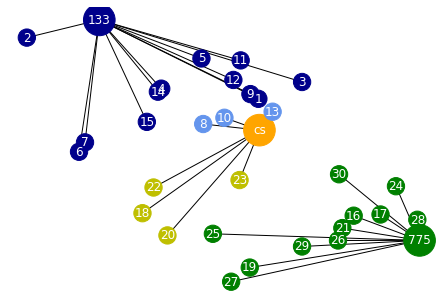

In [100]:
import plotly.graph_objects as go
import networkx as nx

mode='user-assignment'
#mode='comp-gain'

df2 = pd.read_json("Prepro/cell_data.txt")
BS_pos={}
for i in cluster:
    BS_pos.update({i: bs_dict[i]})

G=nx.Graph()

x=np.arange(1,ue_nr*len(cluster))
G.add_node('cs')
for i in cluster:
    G.add_node(str(i))

BS_pos={}
for i in cluster:
    BS_pos.update({i: bs_dict[i]})

loc_list=np.array(list(BS_pos.values()))
loc_dic={}
loc_dic['cs']=[loc_list[:,0].mean(),loc_list[:,1].mean()]

for i in cluster:
    loc_dic[str(i)]=BS_pos[i]

G.add_nodes_from(x)

#n_c=np.array(['orange','darkblue','green'])
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
       # if(i.cell1==cluster[0]):
        #    n_c=np.append(n_c,'cornflowerblue')
        #elif(i.cell1==cluster[1]):
         #   n_c=np.append(n_c,'y')
    else:
        for j in cluster:
            if(i.cell1==j):
                G.add_edge(counter,str(j))
    counter+=1

n_c=np.array(['orange'])
color_selection_bs=['darkblue','green','purple','black','darkred']
color_selection_user=['cornflowerblue','y','plum','gray','red']
if(len(cluster) > len(color_selection_bs)):
    color_selection_bs=[]
    color_selection_user=[]
    for i in cluster:
        color_selection_bs.append('darkblue')
        color_selection_user.append('cornflowerblue')
n_c=np.append(n_c,color_selection_bs[0:len(cluster)])
color_edge_ues = dict(zip(cluster,color_selection_user[0:len(cluster)]))    
color_bs=dict(zip(cluster,color_selection_bs[0:len(cluster)]))  
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
        for j in cluster:
            if(i.cell1==j):
                n_c=np.append(n_c,color_edge_ues[j])        
    else:
        for j in cluster:
            if(i.cell1==j):
                G.add_edge(counter,str(j))
                n_c=np.append(n_c,color_bs[j])
    counter+=1
        
n_s=np.ones(ue_nr*len(cluster)+1+len(cluster))*300
n_s[0:(1+len(cluster))]=1000

m=np.array([])
m=np.append(m,np.ones(len(cluster)+1))
t=np.array([])
t=np.append(t,np.ones(len(cluster)+1))
for i in ue_all:
    m=np.append(m,(i.mR2/i.mR))
    if(i.comp==1):
        t=np.append(t,i.tbs_comp)
    else:
        t=np.append(t,i.tbs)
m[len(cluster):]=10*np.log10(m[len(cluster):])
vmin = np.min(m)
vmax = np.max(m)
m[0:len(cluster)]=np.mean(m[len(cluster):])

if(mode=='user-assignment'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=n_c,font_color='white',node_size=n_s)
elif(mode=='comp-gain'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=m,font_color='white',node_size=n_s,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    x=plt.colorbar(sm)
    x.set_label('CoMP gain in [dB]', rotation=270,labelpad=20)

plt.draw()
plt.show()

## Numerical Results

In [101]:
df_res=eds.ue_to_df(ue_all)
df1=df_res[df_res['TP1']==cluster[0]]
df2=df_res[df_res['TP1']==cluster[1]]

for i in cluster:
    df3=df_res[df_res['TP1']==i]
    print('average comp gain pci '+str(i)+': '+str((df3['mR gain'].mean()-1)*100)+'%')
print('average comp gain: '+str(round(((df1['mR gain'].mean()+df2['mR gain'].mean())/2-1)*100))+'%')

average comp gain pci 133: 3.4038231072545555%
average comp gain pci 775: 13.72716968748855%
average comp gain: 9%


In [102]:
#r='random' 
r='deterministic'

mu=4
env=simpy.Environment()
sched_l=[]
sched3=eds.sched_inst(env)
for i in cluster:
    sched1=eds.sched_inst(env)
    sched_l.append(eds.sched_inst(env))

index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
        counter+=1    
ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

prb_number_comp=eds.calculate_prb_number_comp(ue_all,cluster,max_prb,ue_nr)

env=simpy.Environment()

SCHEDULE_T=2 #Clock of scheduler -> every 2ms

SCHEDULE_T=2 #Clock des Schedulers 
for i in cluster:
    ue_list=ue_per_pci[i]
    for j in ue_list:
        env.process(j.best_effort_stat(env,mu))
    

ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
for i in cluster:
    ue_list=ue_per_pci[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp

env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric,'phaseshift'))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
    prb_number_normal=max_prb-prb_number_comp[i]
    env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
    counter=counter+1
timer=2000
env.run(until=timer)

C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


In [103]:
df_res=eds.ue_to_df(ue_all)
df1=df_res[df_res['TP1']==cluster[0]]
df2=df_res[df_res['TP1']==cluster[1]]

for i in cluster:
    df3=df_res[df_res['TP1']==i]
    print('average comp gain pci '+str(i)+': '+str((df3['mR gain'].mean()-1)*100)+'%')
print('average comp gain: '+str(round(((df1['mR gain'].mean()+df2['mR gain'].mean())/2-1)*100))+'%')

average comp gain pci 133: -10.223509856918078%
average comp gain pci 775: 24.65659408238059%
average comp gain: 7%


In [104]:
comp_user=df_res[df_res['comp']==1]
df_nc=df_res[df_res['comp']==0]

#### Different clusters

In [105]:
sectors= np.array(df['TP1'].unique())
print('pci options for cluster:',sectors)

pci options for cluster: [133 319 132 134 776 775 774 318 320]


In [106]:
#cluster=[134,776,319]
cluster=[133,775]
#cluster=sectors
#cluster=[133,775,319]

index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

In [107]:
Cluster=[[319,775],[320,133],[319,775,320,133],[319,775,320,133,774,318,134,776]]

In [108]:
X={}
cluster_nr=0
for cluster in Cluster:
    #r='random' 
    r='deterministic'

    mu=4
    env=simpy.Environment()
    sched_l=[]
    sched3=eds.sched_inst(env)
    for i in cluster:
        sched1=eds.sched_inst(env)
        sched_l.append(eds.sched_inst(env))

    index=np.zeros([len(cluster),ue_nr])
    for i in np.arange(0,len(cluster)):
        index[i,:]=np.arange(0,ue_nr)
    index=index.astype(int)

    ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
    if(r=='random'):
        counter=0
        for i in cluster:
            index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
            counter+=1    
    ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

    prb_number_comp=eds.calculate_prb_number_comp(ue_all,cluster,max_prb,ue_nr)

    env=simpy.Environment()

    SCHEDULE_T=2 #Clock of scheduler -> every 2ms

    SCHEDULE_T=2 #Clock des Schedulers 
    for i in cluster:
        ue_list=ue_per_pci[i]
        for j in ue_list:
            env.process(j.best_effort_stat(env,mu))


    ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
    for i in cluster:
        ue_list=ue_per_pci[i]
        new_ue_list=np.array([])
        for j in ue_list:
            if(j.comp == 0):
                new_ue_list=np.append(new_ue_list,j)
            else:
                ue_comp=np.append(ue_comp,j)
        ue_dict[i]=new_ue_list #user without comp

    env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric,'phaseshift'))

    counter=0
    for i in cluster:
        ue_list=ue_dict[i]
        ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
        prb_number_normal=max_prb-prb_number_comp[i]
        env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
        counter=counter+1
    timer=2000
    env.run(until=timer)

    df_res=eds.ue_to_df(ue_all)
    x=np.array((df_res['mR gain']-1)*100)
    X[cluster_nr]=x
    cluster_nr+=1

C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eventDrivenSimulation.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


In [109]:
xxx=np.append(np.array(list(X[0])),np.array((list(X[1]))))

size=2
10% Quantil: -25.68674931520233
90% Quantil: 124.87469234006107
50% Quantil (Median): -9.562765556557057
size=3
10% Quantil: -40.24584589352537
90% Quantil: 111.48811297304951
50% Quantil (Median): -12.82606784232898
size=4
10% Quantil: -40.54983567189599
90% Quantil: 121.12049898748714
50% Quantil (Median): 20.91792317624944


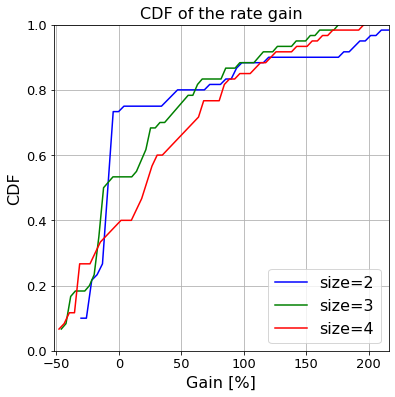

In [110]:
sh.cdf_3(xxx,'size=2','blue',X[2],'size=3','green',X[3][0:60],'size=4','red','CDF of the rate gain',min(x),max(x),'Gain [%]',60)

size=2
10% Quantil: -25.68674931520233
90% Quantil: 124.87469234006107
50% Quantil (Median): -9.562765556557057
size=4
10% Quantil: -40.24584589352537
90% Quantil: 111.48811297304951
50% Quantil (Median): -12.82606784232898


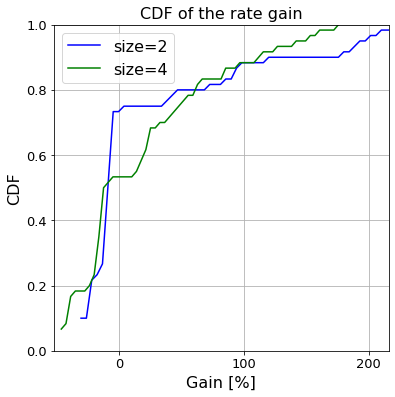

In [111]:
sh.cdf_2(xxx,'size=2','blue',X[2],'size=4','green','CDF of the rate gain',min(x),max(x),'Gain [%]',60)

In [155]:
print(np.mean(xxx))
print(np.mean(X[2]))
print(np.mean(X[3][0:60]))

19.354364729361073
17.661850667787373
29.370911499371463


In [156]:
print(np.mean(xxx[0:15]))
print(np.mean(xxx[15:30]))

print(np.mean(xxx))

-5.2229838501093155
18.202308142049294
19.354364729361073


In [157]:
print(np.mean(X[2][0:15]))
print(np.mean(X[2][15:30]))
print(np.mean(X[2]))

4.081493871035126
27.901247024790134
17.661850667787373


In [118]:
print(np.mean(X[3][0:15]))
print(np.mean(X[3][15:30]))
print(np.mean(X[3][0:60]))

3.894108009687787
43.976303763567564
29.370911499371463


In [119]:
lat=np.array([])
lon=np.array([])
for i in ue_all:
    lat=np.append(lat,i.x)
    lon=np.append(lon,i.y)
df_res['latitude']=lat
df_res['longitude']=lon

In [160]:
df_r=df_res[df_res['mR gain']>1]
df_r2=df_res[df_res['mR gain']<1]

In [150]:
#df['latitude']=df['lat']
#df['longitude']=df['lon']
#df_r=df[df['SINR-CoMP [dB]']-df['SINR [dB]']>6]
#df_r2=df[df['SINR-CoMP [dB]']-df['SINR [dB]']<6]

In [161]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)
folium.Circle(radius = CONFIG['RADIUS'], 
              location = (CONFIG['LAT'], CONFIG['LON']), 
              color = 'blue', 
              fill_color = 'blue',
              fill_opacity = 0.1,
              fill = True,
              weight = 0,
             ).add_to(ul_scenario_map)            
        
for cell in cell_data:
    cell_color = '#1c86ee'
        

    folium.PolyLine(
        create_sector_shape(cell['lon'], cell['lat'], cell['az'], 60), 
        color = cell_color,
        fill_color = cell_color,
       fill_opacity = 0.5, 
        fill = True,
        weight = 2,
        #popup = 'RBs: ' + str(cell['ul_rb_requirement']['mean']),
        tooltip = 'PCI: ' + str(cell['pci'])).add_to(ul_scenario_map)
    
    folium.Circle(radius = 10, 
                  location = (cell['lat'], cell['lon']), 
                  color = 'black', 
                  fill_color = 'black',
                  fill_opacity = 1,
                  fill = True,
                  weight = 0,
                  popup = cell['site_name']
                 ).add_to(ul_scenario_map)
    
    def plotDotGreen(point):
        folium.CircleMarker(location=[point.latitude, point.longitude],radius=1,weight=5,color='green').add_to(ul_scenario_map)
    def plotDotRed(point):
        folium.CircleMarker(location=[point.latitude, point.longitude],radius=1,weight=5,color='red').add_to(ul_scenario_map)

    df_r.apply(plotDotGreen, axis = 1)
    df_r2.apply(plotDotRed, axis = 1)
    


display(ul_scenario_map)